In [1]:
import cv2
from keras.callbacks import *
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.utils import to_categorical
import sys
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def read_img(file_name, color_inv_norm=True):
    """
    read a image from local file system
    :param file_name:
    :param color_inv_norm:
    :return:
    """
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

    if color_inv_norm:
        img = 255 - img

        # img = remove_back(img, np.ones((5, 5), np.uint8))

        img = img / 255.0
    else:
        img[img < 50] = 0
        img = img / 255.0

    return img

In [3]:
def get_data(base_path):
    """

    :param base_path:
    :return:
    """
    nums = os.listdir(base_path)
    train_data = []
    train_label = []
    lbl = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
    for num in tqdm(nums):
        calc = 0
        jpgs = os.listdir(os.path.join(base_path, num))
#         print('-' * 30, 'now load %s' % num, '-' * 30)
        for jpg in jpgs:
            # calc += 1
            # if calc > 5000:
            #     print('the %s data is more than 5000' % num)
                # break

            fname = os.path.join(base_path, num, jpg)
            pic = read_img(fname, color_inv_norm=False)
            train_data.append(pic)
            train_label.append(lbl[int(num)])

    train_data = np.array(train_data)
    train_label = np.array(train_label)
    # print(train_data.shape, train_label.shape)
    # print(train_data)
    # print(np.argmax(train_label, axis=1))
    return train_data, train_label

In [12]:
X, y = get_data('/Users/imperatore/tmp/num_ocr')
X.shape, y.shape

100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


((46524, 48, 48), (46524, 10))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train.shape, y_train.shape

((39545, 48, 48, 1), (39545, 10))

# Model

In [12]:
num_class = 10
input_tensor = Input((48, 48, 1))

In [13]:
def vgg(input_tensor):
    vgg = VGG16(include_top=False, input_tensor=input_tensor)
    return vgg

In [14]:
# def resnet_pretrain(input_tensor):
#     rn = ResNet50(include_top=False, input_tensor=input_tensor)
#     return rn

def resnet(input_tensor, units=32, kernel_size=(3, 3)):
    x = input_tensor
    for i in range(2):
        x  =res_block(x, (2 ** i) * units, kernel_size=kernel_size)
    return x

In [15]:
def conv2d_bn(x, units, kernel_size, strides=(1, 1), padding='same', name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(units, kernel_size, padding=padding, strides=strides, activation='relu', name=conv_name)(x)
    x = BatchNormalization(axis=3, name=bn_name)(x)
    return x

In [16]:
def res_block(inpt, units, kernel_size, strides=(1, 1), with_conv_shortcut=True):
    x = conv2d_bn(inpt, units=units, kernel_size=kernel_size, strides=strides, padding='same')
    x = conv2d_bn(x, units=units, kernel_size=kernel_size, padding='same')
    if with_conv_shortcut:
        shortcut = conv2d_bn(inpt, units=units, strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

In [17]:
def ordinary(x, ite=2):
    for i in range(ite):
        x = Conv2D(32 * 2 ** i, (3, 3), kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(32 * 2 ** 2, (3, 3), kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
    return x

In [90]:
# x = ordinary(input_tensor)
x = resnet(input_tensor, units=32, kernel_size=(3,3))

x = Flatten()(x)
x = Dense(128, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Dense(10, kernel_initializer='he_normal', activation='softmax')(x)
# print('now x\'s shape:', x.shape)

base_model = Model(input=input_tensor, output=x)
modellabels = Input(name='labels', shape=[num_class], dtype='float32')
model = Model(inputs=input_tensor, outputs=x)

/home/lian19931201/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  if sys.path[0] == '':


In [91]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [92]:
model.fit(X_train, y_train)

Epoch 1/1
39545/39545 [==============================] - 2708s 68ms/step - loss: 0.0061


In [4]:
def get_non0_index_scope(l):
    """

    :param l:
    :return:
    """
    if l[0]:
        start = 0
    else:
        start = l.index(True)
    l.reverse()
    if l[0]:
        end = 0
    else:
        end = l.index(True)
    end = len(l) - end
    return start, end


def get_min_content_area(img):
    """

    :param img:
    :return:
    """
    col_proj = (np.sum(img, axis=0) != 0).tolist()
    row_proj = (np.sum(img, axis=1) != 0).tolist()
    col_start, col_end = get_non0_index_scope(col_proj)
    row_start, row_end = get_non0_index_scope(row_proj)

    return row_start, row_end, col_start, col_end


def get_resize_padding_img(img, size=None, padding=None):
    """

    :param img:
    :param size:
    :param padding:
    :return:
    """
    if size and padding:
        sub_img = cv2.resize(img, size)
        sub_img = np.pad(sub_img, padding, mode='constant')
        sub_img = np.pad(sub_img, ((3,), (3,)), mode='constant')
    else:
        sub_img = cv2.resize(img, (28, 28))
    return sub_img

In [5]:
def preprocessing(img):
    row_start, row_end, col_start, col_end = get_min_content_area(img)
    sub_img = img[row_start: row_end, col_start: col_end]
    
    if col_end - col_start < row_end - row_start:  # 铅直边较长
        change_rate = (row_end - row_start - 42) / float((row_end - row_start))
        changed_width = int((col_end - col_start) * (1 - change_rate))

        if changed_width % 2 == 1:
            changed_width += 1
        if changed_width == 0:
            changed_width = 2
        pad = (42 - changed_width) / 2
        padding = ((0,), (int(pad),))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_width, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(changed_width, 42), padding=padding)

    else:  # 水平边较长
        # change_rate = (x1 - x0 - 42) / float((x1 - x0))
        # changed_height = int((y1 - y0) * (1 - change_rate))

        change_rate = (col_end - col_start - 42) / float((col_end - col_start))
        changed_height = int((row_end - row_start) * (1 - change_rate))

        if changed_height % 2 == 1:
            changed_height += 1
        if changed_height == 0:
            changed_height = 2
        pad = (42 - changed_height) / 2
        padding = ((int(pad),), (0,))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_height, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(42, changed_height), padding=padding)

    return sub_img

In [6]:
from keras.models import *
model = load_model('cnn3_gen.h5')

In [ ]:
np.mean(np.argmax(model.predict(X_test[:100]), axis=1) == np.argmax(y_test[:100], axis=1))

In [31]:
np.mean(np.argmax(model.predict(X_test[:1000]), axis=1) == np.argmax(y_test[:1000], axis=1))

1.0

## CNN3

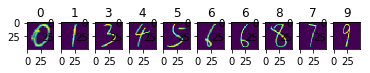

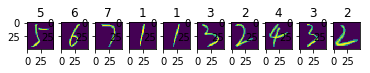

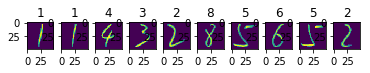

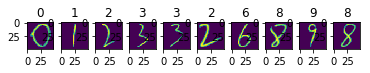

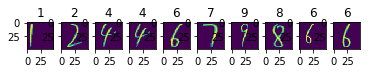

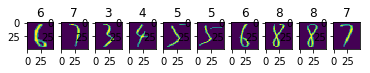

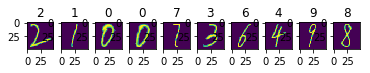

In [23]:
import matplotlib.pyplot as plt
for j in range(0, 7):
    
    for i in range(1, 11):
        img = cv2.imread('testimg/%s/%s.jpg' % (j, i), cv2.IMREAD_GRAYSCALE)
#         img = (255 - img) / 255.0
        img = 255 - img
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img[img < 0.16] = 0.0
        img[img > 0] += 0.2
        img[img > 1.] = 1.
        sub_img = preprocessing(img)

        plt.subplot(7, 10, i + j * 10)
        plt.imshow(sub_img)
        plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, 0), -1))))
    plt.show()

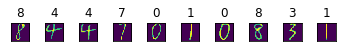

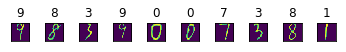

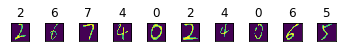

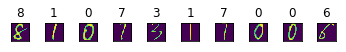

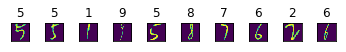

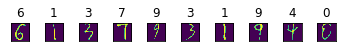

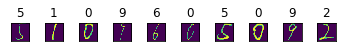

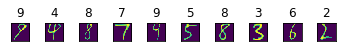

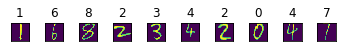

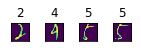

In [24]:
import os
j = 1
for i in os.listdir('F:/nums'):
    
    img = cv2.imread(os.path.join('F:/nums', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.3] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(10, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

---

## CNN4

In [17]:
from keras.models import *
model = load_model('cnn4_gen.h5')

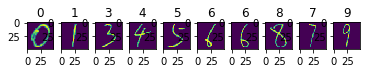

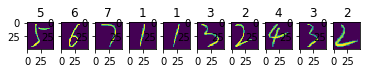

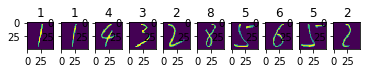

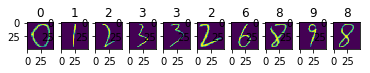

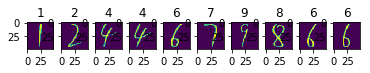

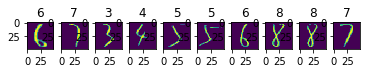

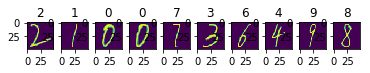

In [18]:
import matplotlib.pyplot as plt
for j in range(0, 7):
    
    for i in range(1, 11):
        img = cv2.imread('testimg/%s/%s.jpg' % (j, i), cv2.IMREAD_GRAYSCALE)
#         img = (255 - img) / 255.0
        img = 255 - img
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img[img < 0.3] = 0.0
        img[img > 0] += 0.2
        img[img > 1.] = 1.
        sub_img = preprocessing(img)

        plt.subplot(7, 10, i + j * 10)
        plt.imshow(sub_img)
        plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, 0), -1))))
    plt.show()

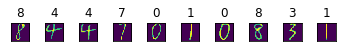

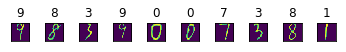

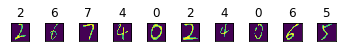

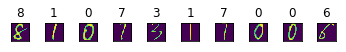

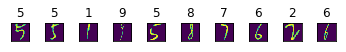

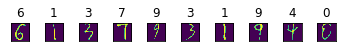

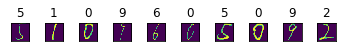

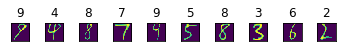

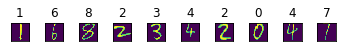

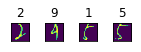

In [19]:
import os
j = 1
for i in os.listdir('F:/nums'):
    
    img = cv2.imread(os.path.join('F:/nums', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.3] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(10, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

---

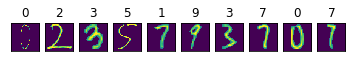

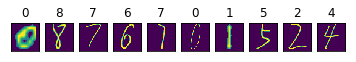

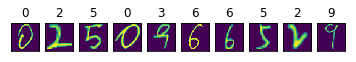

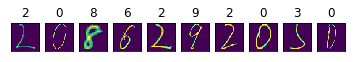

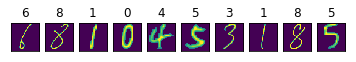

In [38]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\done')
l0 = l[: 50]
l1 = l[50: 100]
l2 = l[100: 150]
l3 = l[150: 200]
l4 = l[200: 250]
l5 = l[250: ]
for i in l0:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

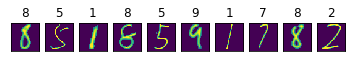

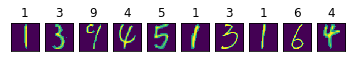

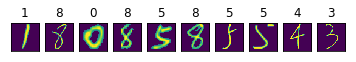

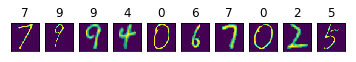

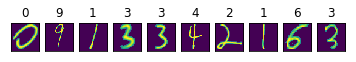

In [26]:
j = 1
for i in l1:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

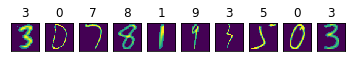

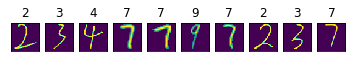

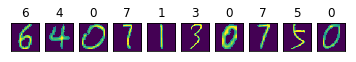

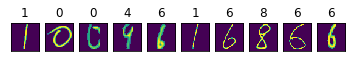

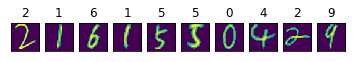

In [28]:
j = 1
for i in l2:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

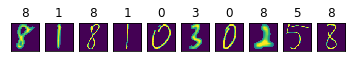

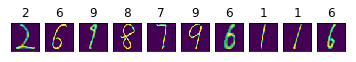

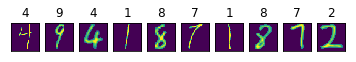

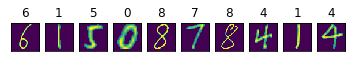

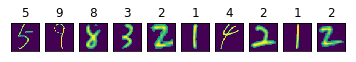

In [29]:
j = 1
for i in l3:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

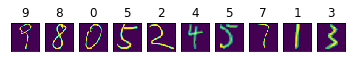

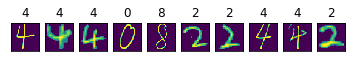

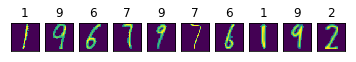

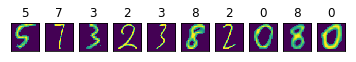

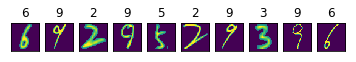

In [30]:
j = 1
for i in l4:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

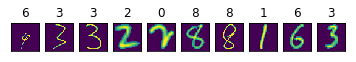

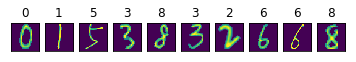

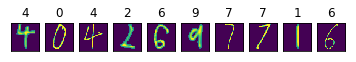

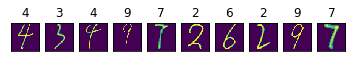

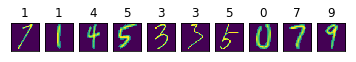

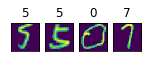

In [34]:
j = 1
for i in l5:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(6, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

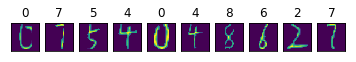

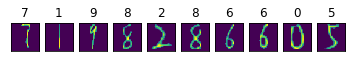

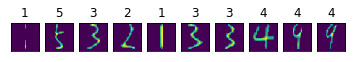

In [42]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\new')

for i in l:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\new', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

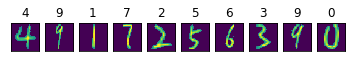

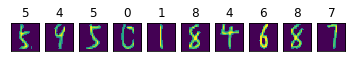

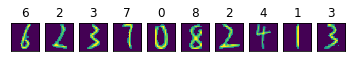

In [43]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\new')

for i in l:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\new', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

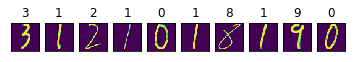

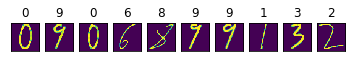

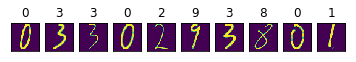

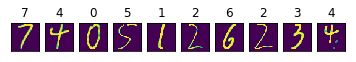

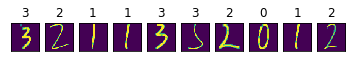

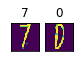

In [47]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\new')

for i in l:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\new', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(6, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

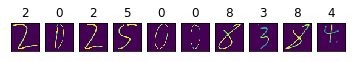

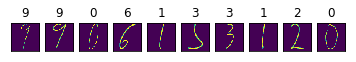

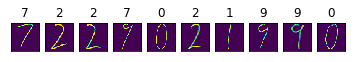

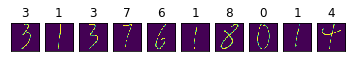

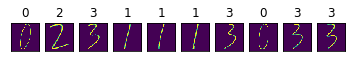

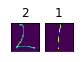

In [49]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\new')

for i in l:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\new', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(6, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

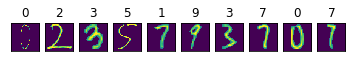

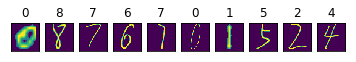

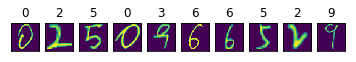

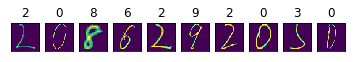

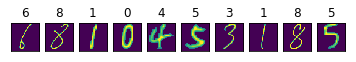

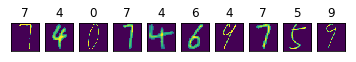

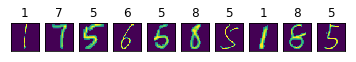

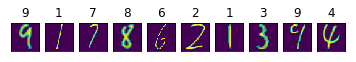

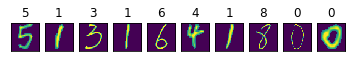

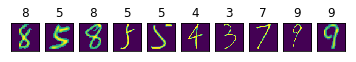

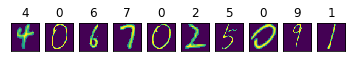

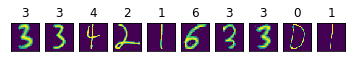

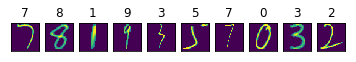

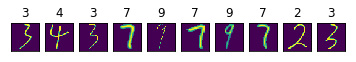

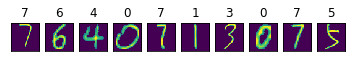

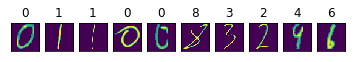

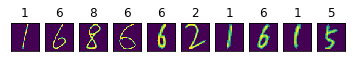

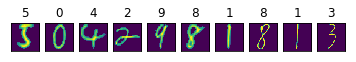

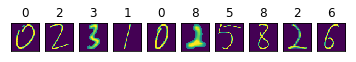

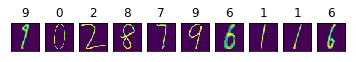

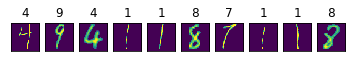

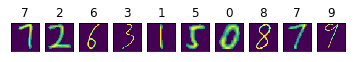

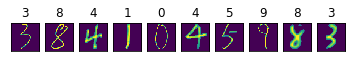

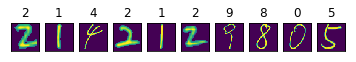

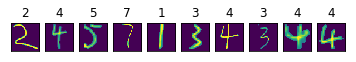

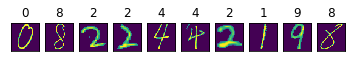

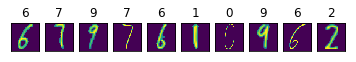

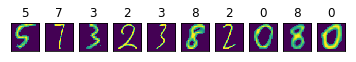

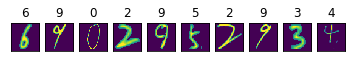

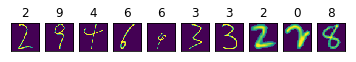

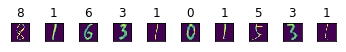

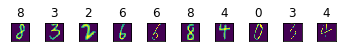

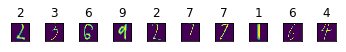

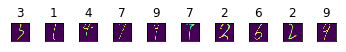

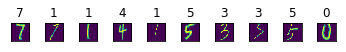

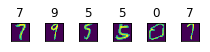

In [53]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\done')
l0 = l[: 50]
l1 = l[50: 100]
l2 = l[100: 150]
l3 = l[150: 200]
l4 = l[200: 250]
l5 = l[250: 300]
l6 = l[300: ]
for i in l0:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

j = 1
for i in l1:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1
    
j = 1
for i in l2:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1
    
j = 1
for i in l3:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1
    
j = 1
for i in l4:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1
    
j = 1
for i in l5:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

j = 1
for i in l6:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(10, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1